<h3>Prediction of game popularity using Machine Learning
(การทำนายความนิยมของเกมด้วย Machine Learning)</h3>

# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install xgboost -U
!pip install catboost -U
!pip install optuna -U
!pip install lightgbm==v2.2.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import os
import pickle
import optuna
import itertools

from numpy import argmax
from keras.models import Sequential
from keras.layers import Dense, InputLayer 
from keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split 

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score

from keras.utils import to_categorical
from catboost import Pool, metrics, cv

# Classification
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/CP499_INDIVIDUAL_COMPUTER_PROJECT_II/data/proprocess_pc_game_data.pkl')
data = data.drop(['Positive_ratings', 'Negative_ratings', 'Year'], axis=1)
data

,Achievements,Average_playtime,Median_playtime,Estimated_sales,Price,Month,Genres_Action,Genres_Adventure,Genres_Animation & Modeling,Genres_Audio Production,...,Developer_rokapublish,Developer_roseVeRte,Developer_stariy8419,Developer_upjers,Developer_vadimalexepta,Developer_КиКо,Developer_凝冰剑斩,Developer_哈视奇科技,Developer_橘子班,Developer_橙光游戏
0,0,17612,317,9,7.19,11,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,277,62,8,3.99,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,187,34,8,3.99,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,258,184,8,3.99,6,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,624,415,8,3.99,11,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27053,7,0,0,0,2.09,4,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27054,0,0,0,0,1.69,4,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27055,24,0,0,0,3.99,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27056,0,0,0,0,5.19,4,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train Models

**train/test split**

In [ ]:
X = data.drop(['Estimated_sales'], axis = 1)
y = data['Estimated_sales']

# แยก train_test_split ด้วยขนาด 80:20 และใช้ random_state ที่ 110
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 110)
sk_folds = StratifiedKFold(n_splits = 5, shuffle=True)

In [ ]:
cv_acc_score = []
cv_f1_score = []
cv_auc_score = []

# Function for Cross Validation
def cross_validation(model):
    scores = ["accuracy", "f1_weighted", "roc_auc_ovr_weighted"]
    for i in scores:
        score = cross_val_score(model, X_train, y_train, cv = sk_folds, scoring = i, n_jobs=-1)

        if i == "accuracy":
          cv_acc_score.append(score.mean())
          print("Cross Validation Accuracy Scores: ", score)
          print("Average CV Accuracy Score: ", score.mean(), "\n")
        elif i == "f1_weighted":
          cv_f1_score.append(score.mean())
          print("Cross Validation F1 Scores: ", score)
          print("Average CV F1 Score: ", score.mean(), "\n")
        else:
          cv_auc_score.append(score.mean())
          print("Cross Validation AUC Scores: ", score)
          print("Average CV AUC Score: ", score.mean(), "\n")

Find the best model from 12 models.

In [ ]:
# Logistic Regression
lr = LogisticRegression()
cross_validation(lr)

Cross Validation Accuracy Scores:  [0.69769053 0.6985447  0.6992377  0.6980827  0.6964657 ]
Average CV Accuracy Score:  0.6980042647017244 

Cross Validation F1 Scores:  [0.60442205 0.61723789 0.60228363 0.61546609 0.62174699]
Average CV F1 Score:  0.6122313293467341 

Cross Validation AUC Scores:  [0.68756159 0.65779342 0.66668597 0.66503216 0.6493115 ]
Average CV AUC Score:  0.6652769293438366 



In [ ]:
# Random Forest
rf = RandomForestClassifier()
cross_validation(rf)

Cross Validation Accuracy Scores:  [0.73117783 0.73088473 0.73111573 0.72857473 0.72834373]
Average CV Accuracy Score:  0.7300193496036452 

Cross Validation F1 Scores:  [0.68726328 0.69520376 0.68125302 0.69209832 0.69884451]
Average CV F1 Score:  0.6909325775319146 

Cross Validation AUC Scores:  [0.9039144  0.90129694 0.89920616 0.90282942 0.89778293]
Average CV AUC Score:  0.9010059714462795 



In [ ]:
# K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier()
cross_validation(knn)

Cross Validation Accuracy Scores:  [0.71177829 0.71032571 0.70755371 0.71309771 0.71286671]
Average CV Accuracy Score:  0.7111244269673831 

Cross Validation F1 Scores:  [0.66903966 0.66733821 0.66672799 0.66789903 0.66614622]
Average CV F1 Score:  0.6674302240463894 

Cross Validation AUC Scores:  [0.80724135 0.80030704 0.8008517  0.80574487 0.80113764]
Average CV AUC Score:  0.803056517947043 



In [ ]:
# Support Vector Machines (SVM)
svm = SVC(probability = True)
cross_validation(svm)

Cross Validation Accuracy Scores:  [0.70577367 0.7047817  0.7024717  0.7033957  0.7036267 ]
Average CV Accuracy Score:  0.7040098972662484 

Cross Validation F1 Scores:  [0.62761138 0.63410088 0.62884825 0.63540485 0.63038744]
Average CV F1 Score:  0.6312705591140043 

Cross Validation AUC Scores:  [0.80872174 0.81277971 0.78647928 0.79299674 0.79156863]
Average CV AUC Score:  0.7985092203751805 



In [ ]:
# Decision Tree
dct = DecisionTreeClassifier()
cross_validation(dct)

Cross Validation Accuracy Scores:  [0.66281755 0.66735967 0.67336567 0.66204666 0.67844768]
Average CV Accuracy Score:  0.6688074466365459 

Cross Validation F1 Scores:  [0.67182124 0.66816189 0.66567707 0.67439959 0.67699706]
Average CV F1 Score:  0.6714113713732779 

Cross Validation AUC Scores:  [0.73036985 0.72816581 0.73302209 0.73137284 0.73137606]
Average CV AUC Score:  0.7308613305537666 



In [ ]:
# Naive Bayes
nb = GaussianNB()
cross_validation(nb)

Cross Validation Accuracy Scores:  [0.30692841 0.32547933 0.35181335 0.34095634 0.33656734]
Average CV Accuracy Score:  0.33234895225657346 

Cross Validation F1 Scores:  [0.43127023 0.43813599 0.45707564 0.43493142 0.43442338]
Average CV F1 Score:  0.43916733174205164 

Cross Validation AUC Scores:  [0.71114823 0.72428702 0.71475208 0.72359057 0.70988149]
Average CV AUC Score:  0.7167318769415129 



In [ ]:
# LightGBM 
lgb = LGBMClassifier()
cross_validation(lgb)

Cross Validation Accuracy Scores:  [0.73048499 0.72718873 0.73180873 0.72534073 0.72603373]
Average CV Accuracy Score:  0.7281713797649133 

Cross Validation F1 Scores:  [0.69361657 0.69891982 0.68959103 0.70672371 0.69321383]
Average CV F1 Score:  0.6964129927968322 

Cross Validation AUC Scores:  [0.90663668 0.89906808 0.90404102 0.89332795 0.89777582]
Average CV AUC Score:  0.9001699108127669 



In [ ]:
# XGBoost
xgb = XGBClassifier() 
cross_validation(xgb)

Cross Validation Accuracy Scores:  [0.72632794 0.73273273 0.73250173 0.73804574 0.73481173]
Average CV Accuracy Score:  0.7328839765329371 

Cross Validation F1 Scores:  [0.69982858 0.70534732 0.70804086 0.70934413 0.70114418]
Average CV F1 Score:  0.7047410145360827 

Cross Validation AUC Scores:  [0.90693015 0.90629642 0.89991547 0.90745353 0.90839932]
Average CV AUC Score:  0.9057989760698966 



In [ ]:
# AdaBoost
ada = AdaBoostClassifier()
cross_validation(ada)

Cross Validation Accuracy Scores:  [0.7        0.7047817  0.70662971 0.7008547  0.61215061]
Average CV Accuracy Score:  0.6848833448833449 

Cross Validation F1 Scores:  [0.66266344 0.6633361  0.66960037 0.61995032 0.64739495]
Average CV F1 Score:  0.6525890364693314 

Cross Validation AUC Scores:  [0.69081743 0.68236049 0.80008323 0.79353084 0.66854708]
Average CV AUC Score:  0.7270678120459378 



In [ ]:
# Gradient Boosting Machine
gbm = GradientBoostingClassifier()
cross_validation(gbm)

Cross Validation Accuracy Scores:  [0.73048499 0.73180873 0.72580273 0.72557173 0.72996073]
Average CV Accuracy Score:  0.7287257803193138 

Cross Validation F1 Scores:  [0.68654909 0.6835377  0.68533832 0.69524051 0.69488419]
Average CV F1 Score:  0.6891099601960506 

Cross Validation AUC Scores:  [0.89813401 0.89253152 0.89148279 0.89010033 0.90257539]
Average CV AUC Score:  0.8949648072173829 



In [ ]:
# CatBoost
cb = CatBoostClassifier(logging_level='Silent')
cross_validation(cb)

Cross Validation Accuracy Scores:  [0.72979215 0.73157773 0.73088473 0.74012474 0.73273273]
Average CV Accuracy Score:  0.733022416625188 

Cross Validation F1 Scores:  [0.69478119 0.70071467 0.6960368  0.70672806 0.70498355]
Average CV F1 Score:  0.700648853716378 

Cross Validation AUC Scores:  [0.90604065 0.90459238 0.90514866 0.90873669 0.90811318]
Average CV AUC Score:  0.9065263121887976 



In [ ]:
# Neural Network
nn = Sequential()
nn.add(Dense(50, input_shape=(X.shape[1],), activation='relu'))
nn.add(BatchNormalization())
nn.add(Dense(40, activation='relu'))
nn.add(BatchNormalization())
nn.add(Dense(10, activation='softmax'))

nn.compile(optimizer="adam", loss="SparseCategoricalCrossentropy", metrics=["accuracy"])
model = KerasClassifier(build_fn = lambda: nn, batch_size=100, verbose=0, epochs=100)
cross_validation(model)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-04 19:59:54         2957
metadata.json                                  2023-05-04 19:59:54           64
variables.h5                                   2023-05-04 19:59:54       300088
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
....

File Name                                             Modified             Size
config.json                                    2023-05-04 20:02:13         2957
metadata.json                                  2023-05-04 20:02:13           64
variables.h5                                   2023-05-04 20:02:13       300088
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-04 20:02:13         2957
metadata.json                                  2023-05-04 20

# Compare Models

In [ ]:
ml_var = [lr, rf, knn, svm, dct, nb, lgb, xgb, ada, gbm, cb, nn]
ml_name = ['Logistic Regression', 'Random Forest', 'K-Nearest Neighbors (KNN)', 'Support Vector Machines (SVM)', 'Decision Tree', 'Naive Bayes', 'LightGBM', 'XGBoost', 'AdaBoost', 'Gradient Boosting Machine', 'CatBoost', 'Neural Network']

**Cross Validation Score**

In [ ]:
# ทำการตรวจสอบความแม่นยำโดยใช้ Accuracy Score / F1 Score / AUC Score (Area Under <ROC> Curve)

cv_score_df = pd.DataFrame(list(zip(ml_name, cv_acc_score, cv_f1_score, cv_auc_score)), columns=['Model', 'Accuracy CV Score', 'F1 CV Score', 'AUC CV Score'])
cv_score_df[cv_score_df.select_dtypes(include=['float64']).columns] *= 100
cv_score_df

,Model,Accuracy CV Score,F1 CV Score,AUC CV Score
0,Logistic Regression,69.800426,61.223133,66.527693
1,Random Forest,73.001935,69.093258,90.100597
2,K-Nearest Neighbors (KNN),71.112443,66.743022,80.305652
3,Support Vector Machines (SVM),70.400990,63.127056,79.850922
4,Decision Tree,66.880745,67.141137,73.086133
5,Naive Bayes,33.234895,43.916733,71.673188
6,LightGBM,72.817138,69.641299,90.016991
7,XGBoost,73.288398,70.474101,90.579898
8,AdaBoost,68.488334,65.258904,72.706781
9,Gradient Boosting Machine,72.872578,68.910996,89.496481


In [ ]:
best_cv_acc_score = max(cv_acc_score)
best_cv_f1_score = max(cv_f1_score)
best_cv_auc_score = max(cv_auc_score)
best_cv_acc_ML = ml_name[cv_acc_score.index(best_cv_acc_score)]
best_cv_f1_ML = ml_name[cv_f1_score.index(best_cv_f1_score)]
best_cv_acc_ML = ml_name[cv_auc_score.index(best_cv_auc_score)]

top_4_cv_model = cv_score_df.sort_values('Accuracy CV Score', ascending=False)['Model'].head(3)
print("Top 4 CV Model:", (top_4_cv_model.to_numpy()), "\n")

best_cv_ml = pd.DataFrame({'Model': [best_cv_acc_ML, best_cv_f1_ML, best_cv_acc_ML], 
                           'Score': [best_cv_acc_score, best_cv_f1_score, best_cv_auc_score]},
                            index=['Best Accuracy', 'Best F1', 'Best AUC'])

best_cv_ml[best_cv_ml.select_dtypes(include=['float64']).columns] *= 100
best_cv_ml

Top 4 CV Model: ['CatBoost' 'XGBoost' 'Random Forest'] 



,Model,Score
Best Accuracy,CatBoost,73.302242
Best F1,XGBoost,70.474101
Best AUC,CatBoost,90.652631


**Train Score**

In [ ]:
# ทำการตรวจสอบความแม่นยำโดยใช้ Accuracy Score / F1 Score / AUC Score (Area Under <ROC> Curve)

auc_train_score = []
acc_train_score = []
F1_train_score = []

best_acc_train_score, best_f1_train_score, best_auc_train_score,= 0, 0, 0
best_acc_train_ML, best_f1_train_ML, best_auc_train_ML = '', '', ''

for x in ml_var:

  if x == nn:
    x.fit(X_train, y_train, batch_size=100, verbose=0, epochs=100)
    nn_pred = x.predict(X_train)
    y_pred = nn_pred.argmax(1) 
    pred_prob = x.predict(X_train)
  else:
    x.fit(X_train, y_train)
    y_pred = x.predict(X_train) 
    pred_prob = x.predict_proba(X_train)  

  # Accuracy Score 
  acc_train_score.append(accuracy_score(y_train, y_pred))
  if accuracy_score(y_train, y_pred) > best_acc_train_score:
    best_acc_train_score = accuracy_score(y_train, y_pred)
    best_acc_train_ML = ml_name[ml_var.index(x)]

  # F1 Score
  F1_train_score.append(f1_score(y_train, y_pred, average='weighted'))
  if f1_score(y_train, y_pred, average='weighted') > best_f1_train_score:
    best_f1_train_score = f1_score(y_train, y_pred, average='weighted')
    best_f1_train_ML = ml_name[ml_var.index(x)]

  # AUC Score
  auc_train_score_cal = roc_auc_score(y_train, pred_prob, multi_class='ovr', average='weighted')
  auc_train_score.append(auc_train_score_cal)
  if auc_train_score_cal > best_auc_train_score:
    best_auc_train_score = auc_train_score_cal
    best_auc_train_ML = ml_name[ml_var.index(x)]

train_score_df = pd.DataFrame(list(zip(ml_name, acc_train_score, F1_train_score, auc_train_score)), columns=['Model', 'Accuracy Train Score', 'F1 Train Score', 'AUC Train Score'])
train_score_df

677/677 [==============================] - 0s 695us/step


,Model,Accuracy Train Score,F1 Train Score,AUC Train Score
0,Logistic Regression,0.697311,0.615147,0.663286
1,Random Forest,0.998152,0.998150,0.999972
2,K-Nearest Neighbors (KNN),0.773399,0.742835,0.951013
3,Support Vector Machines (SVM),0.707475,0.633716,0.803733
4,Decision Tree,0.998244,0.998241,0.999995
5,Naive Bayes,0.385429,0.485043,0.770037
6,LightGBM,0.842742,0.824219,0.945489
7,XGBoost,0.858311,0.844338,0.951510
8,AdaBoost,0.700591,0.667032,0.797476
9,Gradient Boosting Machine,0.783147,0.753594,0.918651


In [ ]:
top_4_train_model = train_score_df .sort_values('Accuracy Train Score', ascending=False)['Model'].head(3)
print("Top 4 Train Model:", (top_4_train_model.to_numpy()), "\n")

best_train_ml = pd.DataFrame({'Model': [best_acc_train_ML, best_f1_train_ML, best_acc_train_ML], 
                        'Score': [best_acc_train_score, best_f1_train_score, best_auc_train_score]},
                        index=['Best Accuracy', 'Best F1', 'Best AUC'])
best_train_ml

Top 4 Train Model: ['Decision Tree' 'Random Forest' 'XGBoost'] 



,Model,Score
Best Accuracy,Decision Tree,0.998244
Best F1,Decision Tree,0.998241
Best AUC,Decision Tree,0.999995


**Test Score**

In [ ]:
# ทำการตรวจสอบความแม่นยำโดยใช้ Accuracy Score / F1 Score / AUC Score (Area Under <ROC> Curve)

auc_test_score = []
acc_test_score = []
F1_test_score = []

best_acc_test_score, best_f1_test_score, best_auc_test_score,= 0, 0, 0
best_acc_test_ML, best_f1_test_ML, best_auc_test_ML = '', '', ''

for x in ml_var:

  if x == nn:
    nn_pred = x.predict(X_test)
    y_pred = nn_pred.argmax(1) 
    pred_prob = x.predict(X_test)
  else:
    y_pred = x.predict(X_test) 
    pred_prob = x.predict_proba(X_test)  

  # Accuracy Score 
  acc_test_score.append(accuracy_score(y_test, y_pred))
  if accuracy_score(y_test, y_pred) > best_acc_test_score:
    best_acc_test_score = accuracy_score(y_test, y_pred)
    best_acc_test_ML = ml_name[ml_var.index(x)]

  # F1 Score
  F1_test_score.append(f1_score(y_test, y_pred, average='weighted'))
  if f1_score(y_test, y_pred, average='weighted') > best_f1_test_score:
    best_f1_test_score = f1_score(y_test, y_pred, average='weighted')
    best_f1_test_ML = ml_name[ml_var.index(x)]

  # AUC Score
  auc_test_score_cal = roc_auc_score(y_test, pred_prob, multi_class='ovr', average='weighted')
  auc_test_score.append(auc_test_score_cal)
  if auc_test_score_cal > best_auc_test_score:
    best_auc_test_score = auc_test_score_cal
    best_auc_test_ML = ml_name[ml_var.index(x)]

test_score_df = pd.DataFrame(list(zip(ml_name, acc_test_score, F1_test_score, auc_test_score)), columns=['Model', 'Accuracy Test Score', 'F1 Test Score', 'AUC Test Score'])
test_score_df

170/170 [==============================] - 0s 825us/step


,Model,Accuracy Test Score,F1 Test Score,AUC Test Score
0,Logistic Regression,0.705469,0.625395,0.680689
1,Random Forest,0.735957,0.699188,0.903124
2,K-Nearest Neighbors (KNN),0.718404,0.678448,0.809087
3,Support Vector Machines (SVM),0.719143,0.646439,0.810314
4,Decision Tree,0.682188,0.681827,0.737424
5,Naive Bayes,0.355506,0.454912,0.719619
6,LightGBM,0.743348,0.715435,0.907398
7,XGBoost,0.742794,0.716126,0.910944
8,AdaBoost,0.708610,0.675662,0.800095
9,Gradient Boosting Machine,0.737435,0.700710,0.898519


In [ ]:
top_4_test_model = test_score_df .sort_values('Accuracy Test Score', ascending=False)['Model'].head(3)
print("Top 4 Test Model:", (top_4_test_model.to_numpy()), "\n")

best_test_ml = pd.DataFrame({'Model': [best_acc_test_ML, best_f1_test_ML, best_acc_test_ML], 
                        'Score': [best_acc_test_score, best_f1_test_score, best_auc_test_score]},
                        index=['Best Accuracy', 'Best F1', 'Best AUC'])
best_test_ml

Top 4 Test Model: ['LightGBM' 'XGBoost' 'CatBoost'] 



,Model,Score
Best Accuracy,LightGBM,0.743348
Best F1,XGBoost,0.716126
Best AUC,LightGBM,0.910944


# Hyperparameter Tuning / Optimize Model Performance

**Set parameter & score for tuning**

In [ ]:
def cb_objective(trial):

    param = {
        "iterations": trial.suggest_int("iterations", 1000, 1500),
        "depth": trial.suggest_int("depth", 1, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
        "border_count": trial.suggest_int("border_count", 128, 254),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb_tuning = CatBoostClassifier(**param, verbose=False)
    rmse = cross_val_score(cb_tuning, X_train, y_train, cv = sk_folds, scoring = "neg_mean_squared_error", n_jobs=-1)
  
    return rmse.mean()

In [ ]:
def xgb_objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_child_weight" : trial.suggest_int("min_child_weight", 1, 10),
        "subsample" : trial.suggest_float("subsample", 0.1, 1),
        "eta" : trial.suggest_float("eta", 0.001, 1),
        "gamma": trial.suggest_float("gamma", 0.001, 1),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1),
        "colsample_bytree" : trial.suggest_float("colsample_bylevel", 0.01, 1),
    }

    xgb_tuning = XGBClassifier(**param) 
    rmse = cross_val_score(xgb_tuning, X_train, y_train, cv = sk_folds, scoring = "neg_mean_squared_error", n_jobs=-1)
  
    return rmse.mean()

In [ ]:
def lgb_objective(trial):

    param = {
        "objective": "multiclass",
        "boosting_type": "gbdt",
        "num_class": 10,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_bin": trial.suggest_int("max_bin", 2, 100),
        "max_depth": trial.suggest_int("max_depth", -5, 25),
        "num_leaves" : trial.suggest_int("num_leaves", 10, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1),
    }

    lgb_tuning = LGBMClassifier(**param)
    rmse = cross_val_score(lgb_tuning, X_train, y_train, cv = sk_folds, scoring = "neg_mean_squared_error", n_jobs=-1)
  
    return rmse.mean()

In [ ]:
def optuna_tuning(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=40, n_jobs=-1, timeout=40000)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    return trial.params

**CatBoost**

In [ ]:
cb_best_param = optuna_tuning(cb_objective)

[I 2023-05-09 05:14:39,960] A new study created in memory with name: no-name-53728001-e20b-4900-9a45-954f43eecd68
[I 2023-05-09 05:57:07,718] Trial 2 finished with value: -0.9562058238732604 and parameters: {'iterations': 1333, 'depth': 9, 'l2_leaf_reg': 6, 'border_count': 146, 'random_strength': 10, 'learning_rate': 0.9818730926734075, 'colsample_bylevel': 0.7280539892376621, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.03162705291342}. Best is trial 2 with value: -0.9562058238732604.
[I 2023-05-09 06:00:20,051] Trial 3 finished with value: -1.1299212945402322 and parameters: {'iterations': 1229, 'depth': 2, 'l2_leaf_reg': 1, 'border_count': 203, 'random_strength': 8, 'learning_rate': 0.693180405789482, 'colsample_bylevel': 0.623319154679843, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.859490429448838}. Best is trial 2 with value: -0.9562058238732604.
[I 2023-05-09 06:12:05,426] Trial 0 finished with value: -0.8191785461069527 and parameters: {'iterations': 1039, 

Number of finished trials: 40
Best trial:
  Value: -0.8094344868940713
  Params: 
    iterations: 1440
    depth: 4
    l2_leaf_reg: 8
    border_count: 199
    random_strength: 6
    learning_rate: 0.6018517199262312
    colsample_bylevel: 0.5746429728448883
    bootstrap_type: Bernoulli
    subsample: 0.6235397258986014


**XGBoost**

In [ ]:
xgb_best_param = optuna_tuning(xgb_objective)

[I 2023-05-08 22:34:45,881] A new study created in memory with name: no-name-dbe26603-5167-4e0e-b4a3-e763f25aad79
[I 2023-05-08 22:43:49,717] Trial 5 finished with value: -0.9732062031831085 and parameters: {'n_estimators': 762, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.1739131609838923, 'eta': 0.2110313607976886, 'gamma': 0.4297608739220648, 'learning_rate': 0.10446530187479212, 'colsample_bylevel': 0.06142652090410387}. Best is trial 5 with value: -0.9732062031831085.
[I 2023-05-08 22:57:45,443] Trial 2 finished with value: -1.0079451809243956 and parameters: {'n_estimators': 334, 'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.44178083588691, 'eta': 0.27361211706594657, 'gamma': 0.5719468105471616, 'learning_rate': 0.557306689353242, 'colsample_bylevel': 0.03273836737243871}. Best is trial 5 with value: -0.9732062031831085.
[I 2023-05-08 22:58:02,605] Trial 1 finished with value: -0.9307002721321428 and parameters: {'n_estimators': 768, 'max_depth': 6, 'min_child_

[I 2023-05-09 01:52:23,997] Trial 26 finished with value: -1.012243737786463 and parameters: {'n_estimators': 795, 'max_depth': 1, 'min_child_weight': 10, 'subsample': 0.5335717293092693, 'eta': 0.8497948815153039, 'gamma': 0.6140299281384171, 'learning_rate': 0.14474945148474724, 'colsample_bylevel': 0.1085267449353294}. Best is trial 19 with value: -0.8560477407590572.
[I 2023-05-09 01:54:03,855] Trial 20 finished with value: -0.9950549519140743 and parameters: {'n_estimators': 667, 'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.46012857450690337, 'eta': 0.5161439431219582, 'gamma': 0.9895093205036768, 'learning_rate': 0.6872282849519826, 'colsample_bylevel': 0.4206278021684773}. Best is trial 19 with value: -0.8560477407590572.
[I 2023-05-09 02:13:06,059] Trial 10 finished with value: -1.0247167686428655 and parameters: {'n_estimators': 767, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.5248028490331748, 'eta': 0.011579050058156792, 'gamma': 0.6747426183176901, 'lear

Number of finished trials: 40
Best trial:
  Value: -0.8560477407590572
  Params: 
    n_estimators: 186
    max_depth: 3
    min_child_weight: 1
    subsample: 0.5303005375592955
    eta: 0.3922157240932291
    gamma: 0.7466064236444101
    learning_rate: 0.3326899577635064
    colsample_bylevel: 0.7815275907063431


**LightGBM**

In [ ]:
lgb_best_param = optuna_tuning(lgb_objective)

[I 2023-05-14 04:41:24,376] A new study created in memory with name: no-name-cf590110-8c9e-42e9-ba91-0fbe838f3fbb
[I 2023-05-14 04:42:00,703] Trial 2 finished with value: -2.734672078367228 and parameters: {'n_estimators': 402, 'max_bin': 13, 'max_depth': 20, 'num_leaves': 53, 'learning_rate': 0.7433395089957971}. Best is trial 2 with value: -2.734672078367228.
[I 2023-05-14 04:42:24,365] Trial 0 finished with value: -2.849008400832881 and parameters: {'n_estimators': 770, 'max_bin': 28, 'max_depth': 11, 'num_leaves': 73, 'learning_rate': 0.3981784892235439}. Best is trial 2 with value: -2.734672078367228.
[I 2023-05-14 04:42:57,868] Trial 1 finished with value: -3.6966163961083125 and parameters: {'n_estimators': 928, 'max_bin': 69, 'max_depth': 25, 'num_leaves': 78, 'learning_rate': 0.4018746660059515}. Best is trial 2 with value: -2.734672078367228.
[I 2023-05-14 04:43:53,038] Trial 4 finished with value: -4.911620474622784 and parameters: {'n_estimators': 262, 'max_bin': 59, 'max_d

Number of finished trials: 40
Best trial:
  Value: -0.8286072393231747
  Params: 
    n_estimators: 512
    max_bin: 96
    max_depth: -3
    num_leaves: 47
    learning_rate: 0.05039807474373025


# Evaluate Model

**Confusion Matrix**

In [ ]:
labels = target_names = ["Class0", "Class1", "Class2", "Class3", "Class4", "Class5", "Class6", "Class7", "Class8", "Class9"]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def predict_cm(model):
  y_pred = model.predict(X_test) 
  cm = confusion_matrix(y_pred, y_test)
  return [y_pred, cm]

**CatBoost**

Normalized confusion matrix
[[8.70702179e-01 8.52300242e-02 2.76029056e-02 1.11380145e-02
  4.84261501e-03 4.84261501e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.79683377e-01 3.72031662e-01 1.82058047e-01 9.49868074e-02
  5.27704485e-02 1.31926121e-02 5.27704485e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.24401914e-01 2.44019139e-01 3.15789474e-01 1.86602871e-01
  1.00478469e-01 1.43540670e-02 9.56937799e-03 4.78468900e-03
  0.00000000e+00 0.00000000e+00]
 [5.66801619e-02 1.61943320e-01 1.82186235e-01 2.18623482e-01
  2.75303644e-01 8.50202429e-02 1.21457490e-02 8.09716599e-03
  0.00000000e+00 0.00000000e+00]
 [2.40549828e-02 7.21649485e-02 1.13402062e-01 2.26804124e-01
  3.84879725e-01 1.09965636e-01 4.46735395e-02 2.40549828e-02
  0.00000000e+00 0.00000000e+00]
 [4.41176471e-02 0.00000000e+00 5.88235294e-02 1.61764706e-01
  2.35294118e-01 2.05882353e-01 1.47058824e-01 8.82352941e-02
  4.41176471e-02 1.47058824e-02]
 [0.00000000e+00 0.00000000e+0

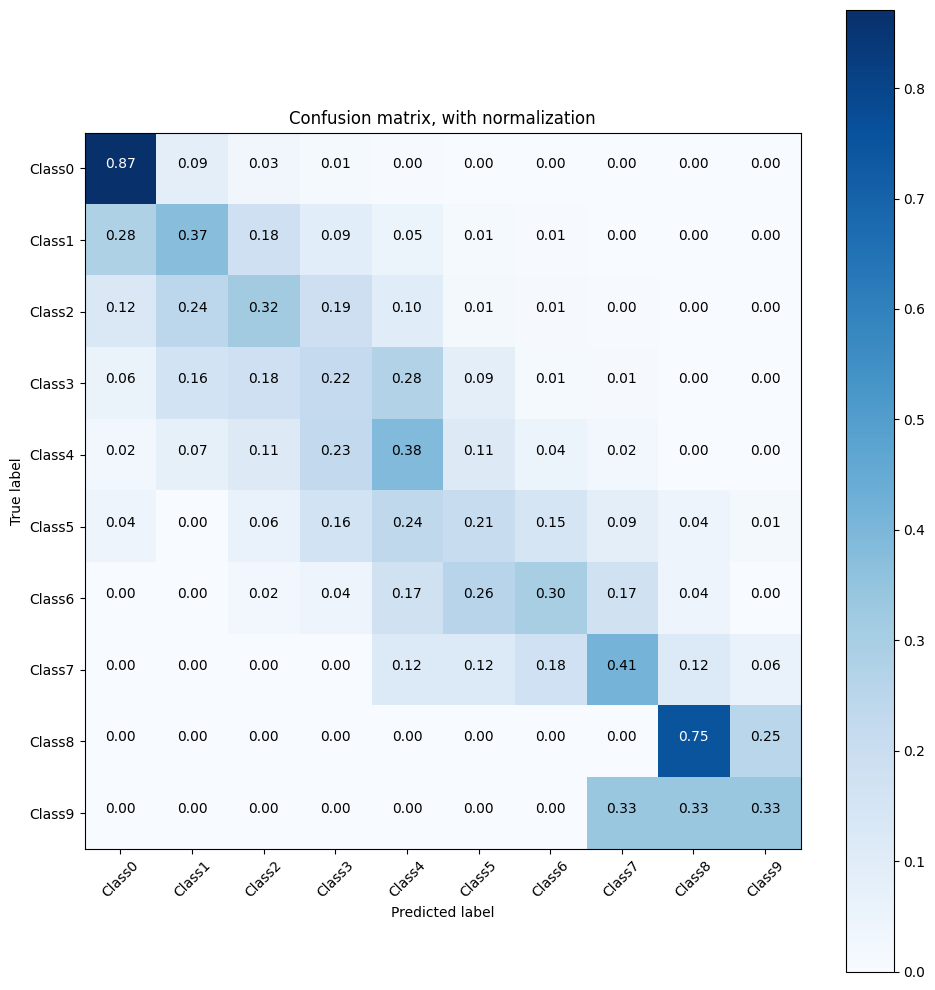

In [ ]:
cb_tuning = CatBoostClassifier(**cb_best_param, logging_level='Silent')
cb_tuning.fit(X_train, y_train)
cm1 = predict_cm(cb_tuning)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm1[1], classes=labels, normalize='True',
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
print(classification_report(cm1[0], y_test, target_names=target_names))

              precision    recall  f1-score   support

      Class0       0.96      0.87      0.91      4130
      Class1       0.23      0.37      0.29       379
      Class2       0.20      0.32      0.24       209
      Class3       0.21      0.22      0.22       247
      Class4       0.42      0.38      0.40       291
      Class5       0.15      0.21      0.17        68
      Class6       0.28      0.30      0.29        47
      Class7       0.36      0.41      0.38        34
      Class8       0.23      0.75      0.35         4
      Class9       0.20      0.33      0.25         3

    accuracy                           0.74      5412
   macro avg       0.32      0.42      0.35      5412
weighted avg       0.79      0.74      0.76      5412



In [ ]:
pickle.dump(cb_tuning, open('/content/drive/MyDrive/CP499_INDIVIDUAL_COMPUTER_PROJECT_II/Tuning_Model/With0ut_Rating/no_ratings_cb_tuning.pkl', 'wb'))

**XGBoost**

Normalized confusion matrix
[[0.86782983 0.08819312 0.02772467 0.01123327 0.00501912 0.
  0.         0.         0.         0.        ]
 [0.19889503 0.36740331 0.20441989 0.13812155 0.07734807 0.00828729
  0.00552486 0.         0.         0.        ]
 [0.13089005 0.2460733  0.27748691 0.20418848 0.11518325 0.02094241
  0.0052356  0.         0.         0.        ]
 [0.04651163 0.14883721 0.2        0.21395349 0.27906977 0.09302326
  0.01395349 0.00465116 0.         0.        ]
 [0.0367893  0.08026756 0.13712375 0.20401338 0.35785953 0.1270903
  0.0367893  0.01672241 0.         0.00334448]
 [0.04166667 0.         0.06944444 0.125      0.25       0.19444444
  0.20833333 0.08333333 0.02777778 0.        ]
 [0.         0.         0.         0.03921569 0.23529412 0.21568627
  0.23529412 0.21568627 0.03921569 0.01960784]
 [0.         0.         0.         0.         0.         0.1
  0.2        0.5        0.1        0.1       ]
 [0.         0.         0.         0.         0.16666667 0.
  0.    

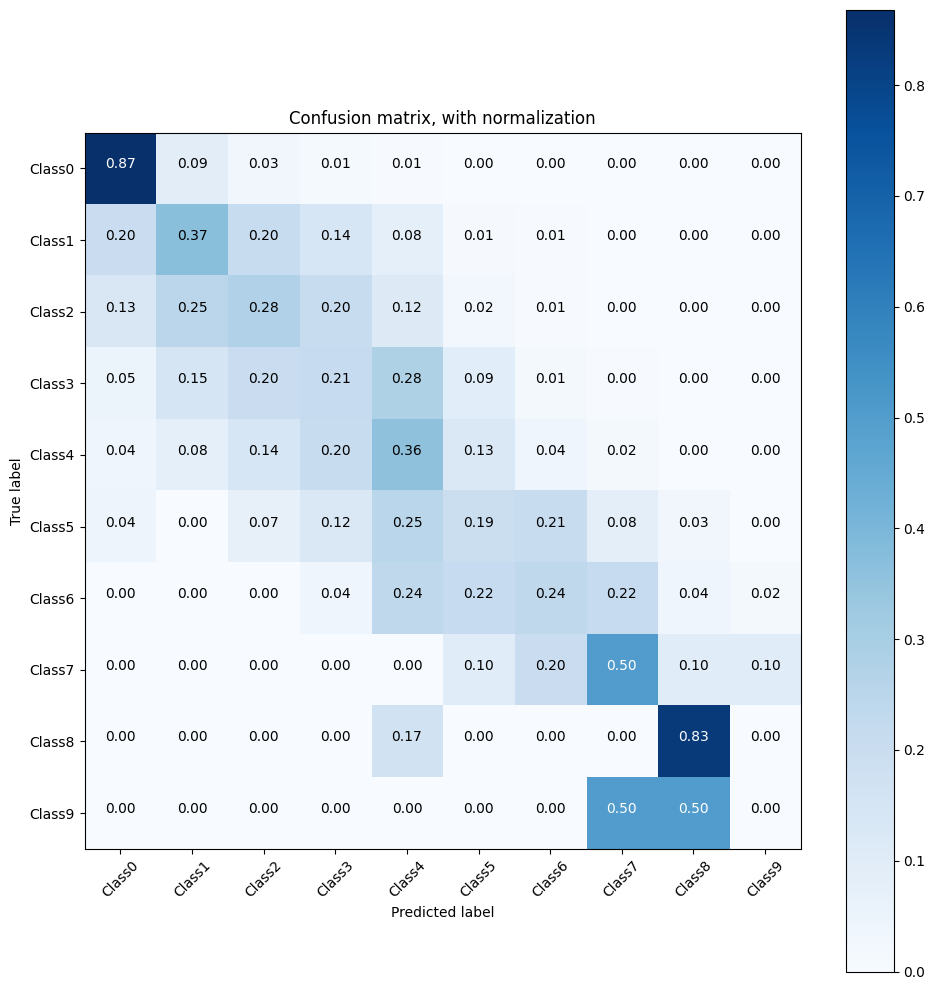

In [ ]:
xgb_tuning = XGBClassifier(**xgb_best_param) 
xgb_tuning.fit(X_train, y_train)
cm2 = predict_cm(xgb_tuning)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm2[1], classes=labels, normalize='True',
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
print(classification_report(cm2[0], y_test, target_names=target_names))

              precision    recall  f1-score   support

      Class0       0.97      0.87      0.92      4184
      Class1       0.22      0.37      0.28       362
      Class2       0.16      0.28      0.20       191
      Class3       0.18      0.21      0.20       215
      Class4       0.40      0.36      0.38       299
      Class5       0.15      0.19      0.17        72
      Class6       0.24      0.24      0.24        51
      Class7       0.38      0.50      0.43        30
      Class8       0.38      0.83      0.53         6
      Class9       0.00      0.00      0.00         2

    accuracy                           0.74      5412
   macro avg       0.31      0.38      0.33      5412
weighted avg       0.80      0.74      0.77      5412



In [ ]:
pickle.dump(xgb_tuning, open('/content/drive/MyDrive/CP499_INDIVIDUAL_COMPUTER_PROJECT_II/Tuning_Model/With0ut_Rating/no_ratings_xgb_tuning.pkl', 'wb'))

**LightGBM**

Normalized confusion matrix
[[8.72938894e-01 8.75363725e-02 2.57032008e-02 9.69932105e-03
  3.87972842e-03 2.42483026e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.60416667e-01 3.38541667e-01 1.90104167e-01 1.32812500e-01
  6.77083333e-02 7.81250000e-03 2.60416667e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.07843137e-01 2.25490196e-01 3.48039216e-01 1.86274510e-01
  7.84313725e-02 3.43137255e-02 1.47058824e-02 4.90196078e-03
  0.00000000e+00 0.00000000e+00]
 [7.50988142e-02 1.73913043e-01 1.69960474e-01 2.25296443e-01
  2.76679842e-01 6.32411067e-02 1.18577075e-02 3.95256917e-03
  0.00000000e+00 0.00000000e+00]
 [3.18471338e-02 7.64331210e-02 1.21019108e-01 1.87898089e-01
  3.98089172e-01 1.11464968e-01 4.77707006e-02 2.22929936e-02
  3.18471338e-03 0.00000000e+00]
 [1.72413793e-02 0.00000000e+00 1.72413793e-02 8.62068966e-02
  1.55172414e-01 3.62068966e-01 2.58620690e-01 5.17241379e-02
  3.44827586e-02 1.72413793e-02]
 [0.00000000e+00 0.00000000e+0

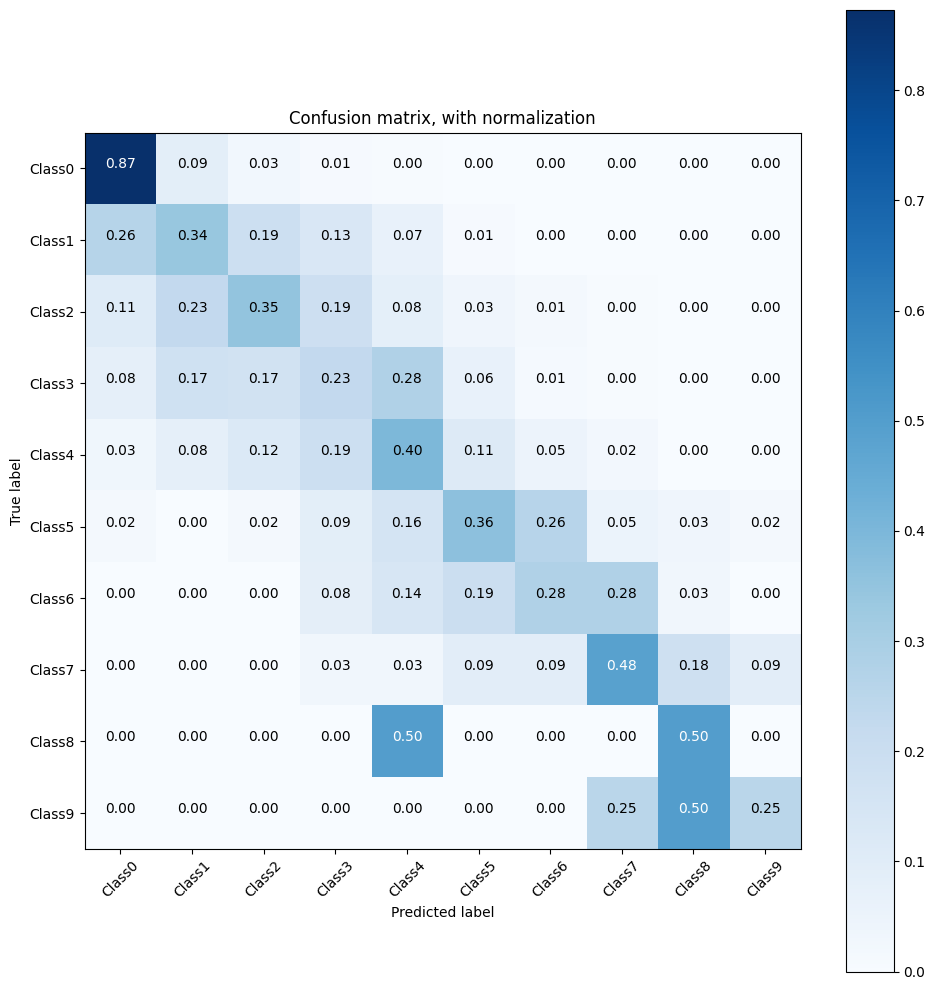

In [ ]:
# LightGBM 
lgb_tuning = LGBMClassifier(**lgb_best_param)
lgb_tuning.fit(X_train, y_train)
cm3 = predict_cm(lgb_tuning)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm3[1], classes=labels, normalize='True',
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
print(classification_report(cm3[0], y_test, target_names=target_names))

              precision    recall  f1-score   support

      Class0       0.96      0.87      0.91      4124
      Class1       0.21      0.34      0.26       384
      Class2       0.21      0.35      0.26       204
      Class3       0.22      0.23      0.22       253
      Class4       0.46      0.40      0.43       314
      Class5       0.23      0.36      0.28        58
      Class6       0.20      0.28      0.23        36
      Class7       0.41      0.48      0.44        33
      Class8       0.08      0.50      0.13         2
      Class9       0.20      0.25      0.22         4

    accuracy                           0.75      5412
   macro avg       0.32      0.41      0.34      5412
weighted avg       0.80      0.75      0.77      5412



In [ ]:
pickle.dump(lgb_tuning, open('/content/drive/MyDrive/CP499_INDIVIDUAL_COMPUTER_PROJECT_II/Tuning_Model/With0ut_Rating/no_ratings_lgb_tuning.pkl', 'wb'))

# Feature Importance

In [ ]:
def drop_features_less_importances(models):
    data_drop_feat = data
    importances_model = models.feature_importances_
    importances = []
    features = []

    # Sort the feature importance in descending order
    sorted_indices = np.argsort(importances_model)[::-1]
    feat_labels = data.columns

    for f in range(X.shape[1]):
      u = feat_labels[sorted_indices[f]]
      d = "Steamspy_tags_Other"
      if u != d:
        if (u[0:5] == d[0:5]):
          importances.append(importances_model[sorted_indices[f]])
          features.append(feat_labels[sorted_indices[f]])
    
    importances_model = pd.DataFrame.from_dict(data = {'features': features, 'importances': importances})
    less_importances_features = importances_model[importances_model['importances'] <= 0]

    for i in less_importances_features["features"]:
      data_drop_feat = data_drop_feat.drop([i], axis = 1)
    
    X_drop_feat = data_drop_feat.drop(['Estimated_sales'], axis = 1)
    y_drop_feat = data_drop_feat['Estimated_sales']

    return [X_drop_feat, y_drop_feat, data_drop_feat]

In [ ]:
cb_drop_feat = CatBoostClassifier(**cb_best_param, logging_level='Silent')
xgb_drop_feat = XGBClassifier(**xgb_best_param) 
lgb_drop_feat = LGBMClassifier(**lgb_best_param)

In [ ]:
ml_tuning = [cb_tuning, xgb_tuning, lgb_tuning]

for x in ml_tuning:
  data_drop_features = drop_features_less_importances(x)
  X_train , X_test , y_train , y_test = train_test_split(data_drop_features[0] , data_drop_features[1] , test_size = 0.2 , random_state = 110)
  
  if x == cb_tuning:
    cb_drop_feat.fit(X_train, y_train)
  elif x ==  xgb_tuning: 
    xgb_drop_feat.fit(X_train, y_train)
  else:
    lgb_drop_feat.fit(X_train, y_train)

# Result

In [ ]:
ml_var = [cb, cb_tuning, cb_drop_feat, xgb, xgb_tuning, xgb_drop_feat, lgb, lgb_tuning, lgb_drop_feat]
ml_name = [
    'CatBoost', 'CatBoost Tuning', 'CatBoost Drop Feature', 
    'XGBoost', 'XGBoost Tuning', 'XGBoost Drop Feature', 
    'LightGBM', 'LightGBM Tuning', 'LightGBM Drop Feature'
]
ml_drop_feat = [cb_drop_feat, xgb_drop_feat, lgb_drop_feat]

**Train Score**

In [ ]:
# ทำการตรวจสอบความแม่นยำโดยใช้ Accuracy Score / F1 Score / AUC Score (Area Under <ROC> Curve)
auc_train_score = []
acc_train_score = []
F1_train_score = []

best_acc_train_score, best_f1_train_score, best_auc_train_score,= 0, 0, 0
best_acc_train_ML, best_f1_train_ML, best_auc_train_ML = '', '', ''

for x in ml_var:

  if x in ml_drop_feat:
      if x == cb_drop_feat:
        z = cb_tuning
      elif x ==  xgb_drop_feat: 
        z = xgb_tuning
      else:
        z = lgb_tuning

      data_drop_features = drop_features_less_importances(z)
      X_train , X_test , y_train , y_test = train_test_split(data_drop_features[0] , data_drop_features[1] , test_size = 0.2 , random_state = 110) 
  else:
      X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 110)

  y_pred = x.predict(X_train) 
  pred_prob = x.predict_proba(X_train)  

  # Accuracy Score 
  acc_train_score.append(accuracy_score(y_train, y_pred))
  if accuracy_score(y_train, y_pred) > best_acc_train_score:
    best_acc_train_score = accuracy_score(y_train, y_pred)
    best_acc_train_ML = ml_name[ml_var.index(x)]

  # F1 Score
  F1_train_score.append(f1_score(y_train, y_pred, average='weighted'))
  if f1_score(y_train, y_pred, average='weighted') > best_f1_train_score:
    best_f1_train_score = f1_score(y_train, y_pred, average='weighted')
    best_f1_train_ML = ml_name[ml_var.index(x)]

  # AUC Score
  auc_train_score_cal = roc_auc_score(y_train, pred_prob, multi_class='ovr', average='weighted')
  auc_train_score.append(auc_train_score_cal)
  if auc_train_score_cal > best_auc_train_score:
    best_auc_train_score = auc_train_score_cal
    best_auc_train_ML = ml_name[ml_var.index(x)]

train_score_df = pd.DataFrame(list(zip(ml_name, acc_train_score, F1_train_score, auc_train_score)), columns=['Model', 'Accuracy Train Score', 'F1 Train Score', 'AUC Train Score'])
train_score_df

,Model,Accuracy Train Score,F1 Train Score,AUC Train Score
0,CatBoost,0.801811,0.778386,0.932596
1,CatBoost Tuning,0.840663,0.826500,0.950032
2,CatBoost Drop Feature,0.834889,0.819991,0.947801
3,XGBoost,0.858311,0.844338,0.951510
4,XGBoost Tuning,0.813268,0.792529,0.938157
5,XGBoost Drop Feature,0.814885,0.794394,0.937045
6,LightGBM,0.842742,0.824219,0.945489
7,LightGBM Tuning,0.928024,0.922372,0.980754
8,LightGBM Drop Feature,0.922803,0.916657,0.979283


**Test Score**

In [ ]:
# ทำการตรวจสอบความแม่นยำโดยใช้ Accuracy Score / F1 Score / AUC Score (Area Under <ROC> Curve)
auc_test_score = []
acc_test_score = []
F1_test_score = []

best_acc_test_score, best_f1_test_score, best_auc_test_score,= 0, 0, 0
best_acc_test_ML, best_f1_test_ML, best_auc_test_ML = '', '', ''

for x in ml_var:

  if x in ml_drop_feat:
      if x == cb_drop_feat:
        z = cb_tuning
      elif x ==  xgb_drop_feat: 
        z = xgb_tuning
      else:
        z = lgb_tuning

      data_drop_features = drop_features_less_importances(z)
      X_train , X_test , y_train , y_test = train_test_split(data_drop_features[0] , data_drop_features[1] , test_size = 0.2 , random_state = 110) 
  else:
      X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 110)

  y_pred = x.predict(X_test) 
  pred_prob = x.predict_proba(X_test)  

  # Accuracy Score 
  acc_test_score.append(accuracy_score(y_test, y_pred))
  if accuracy_score(y_test, y_pred) > best_acc_test_score:
    best_acc_test_score = accuracy_score(y_test, y_pred)
    best_acc_test_ML = ml_name[ml_var.index(x)]

  # F1 Score
  F1_test_score.append(f1_score(y_test, y_pred, average='weighted'))
  if f1_score(y_test, y_pred, average='weighted') > best_f1_test_score:
    best_f1_test_score = f1_score(y_test, y_pred, average='weighted')
    best_f1_test_ML = ml_name[ml_var.index(x)]

  # AUC Score
  auc_test_score_cal = roc_auc_score(y_test, pred_prob, multi_class='ovr', average='weighted')
  auc_test_score.append(auc_test_score_cal)
  if auc_test_score_cal > best_auc_test_score:
    best_auc_test_score = auc_test_score_cal
    best_auc_test_ML = ml_name[ml_var.index(x)]

test_score_df = pd.DataFrame(list(zip(ml_name, acc_test_score, F1_test_score, auc_test_score)), columns=['Model', 'Accuracy Test Score', 'F1 Test Score', 'AUC Test Score'])
test_score_df

,Model,Accuracy Test Score,F1 Test Score,AUC Test Score
0,CatBoost,0.739653,0.709248,0.910274
1,CatBoost Tuning,0.741870,0.719086,0.912255
2,CatBoost Drop Feature,0.748152,0.725465,0.913247
3,XGBoost,0.742794,0.716126,0.910944
4,XGBoost Tuning,0.742055,0.715020,0.910767
5,XGBoost Drop Feature,0.740207,0.713054,0.909752
6,LightGBM,0.743348,0.715435,0.907398
7,LightGBM Tuning,0.745011,0.721934,0.910962
8,LightGBM Drop Feature,0.740761,0.717319,0.907278


In [ ]:
best_test_ml = pd.DataFrame({'Model': [best_acc_test_ML, best_f1_test_ML, best_acc_test_ML], 
                        'Score': [best_acc_test_score, best_f1_test_score, best_auc_test_score]},
                        index=['Best Accuracy', 'Best F1', 'Best AUC'])
best_test_ml

,Model,Score
Best Accuracy,CatBoost Drop Feature,0.748152
Best F1,CatBoost Drop Feature,0.725465
Best AUC,CatBoost Drop Feature,0.913247


Normalized confusion matrix
[[8.72881356e-01 8.57142857e-02 2.59079903e-02 1.11380145e-02
  4.11622276e-03 2.42130751e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.41813602e-01 3.67758186e-01 2.09068010e-01 1.15869018e-01
  5.79345088e-02 5.03778338e-03 2.51889169e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.48514851e-01 2.42574257e-01 3.46534653e-01 1.58415842e-01
  6.93069307e-02 2.97029703e-02 4.95049505e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.35714286e-02 1.47321429e-01 1.56250000e-01 2.45535714e-01
  2.85714286e-01 8.48214286e-02 1.33928571e-02 1.33928571e-02
  0.00000000e+00 0.00000000e+00]
 [2.68456376e-02 7.04697987e-02 1.00671141e-01 2.11409396e-01
  4.16107383e-01 1.07382550e-01 5.03355705e-02 1.67785235e-02
  0.00000000e+00 0.00000000e+00]
 [1.28205128e-02 2.56410256e-02 7.69230769e-02 1.41025641e-01
  2.43589744e-01 2.56410256e-01 1.41025641e-01 7.69230769e-02
  1.28205128e-02 1.28205128e-02]
 [0.00000000e+00 0.00000000e+0

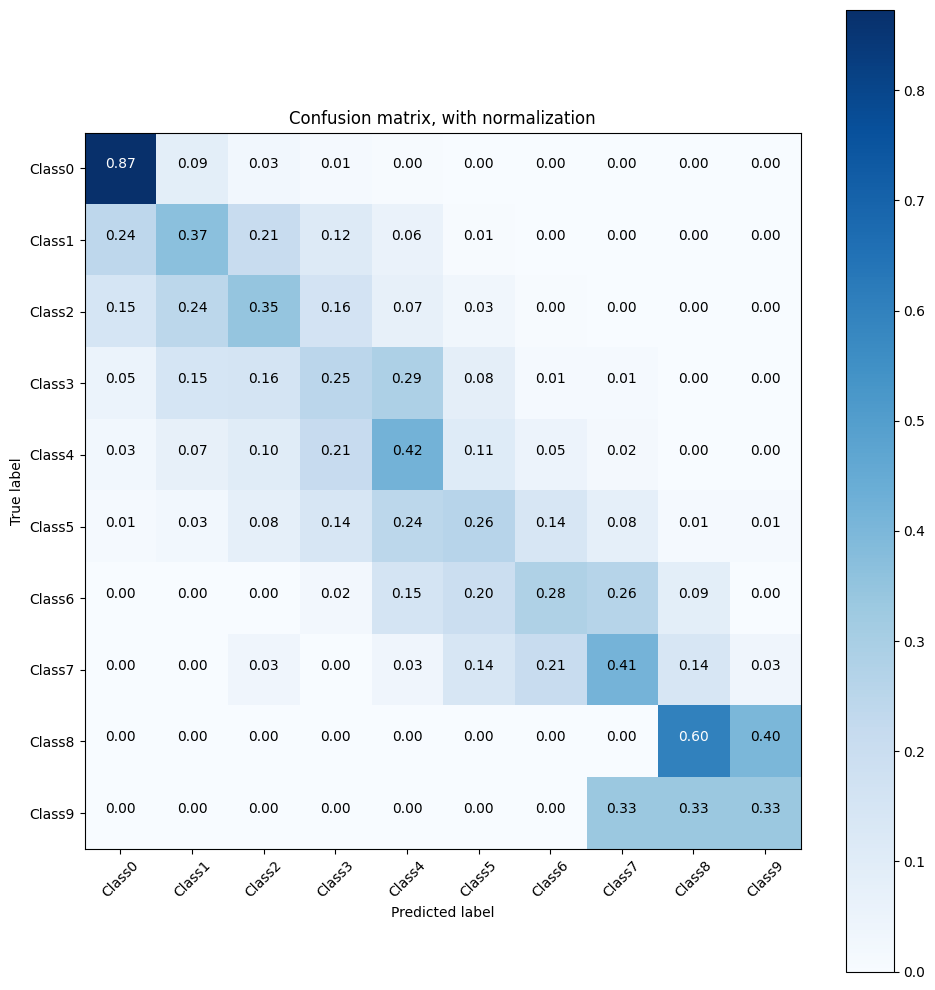

In [ ]:
data_drop_features = drop_features_less_importances(cb_tuning)
X_train , X_test , y_train , y_test = train_test_split(data_drop_features[0] , data_drop_features[1] , test_size = 0.2 , random_state = 110)
  
cm = predict_cm(cb_drop_feat)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm[1], classes=labels, normalize='True',
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
print(classification_report(cm[0], y_test, target_names=target_names))

              precision    recall  f1-score   support

      Class0       0.96      0.87      0.91      4130
      Class1       0.24      0.37      0.29       397
      Class2       0.21      0.35      0.26       202
      Class3       0.22      0.25      0.23       224
      Class4       0.46      0.42      0.44       298
      Class5       0.22      0.26      0.23        78
      Class6       0.26      0.28      0.27        46
      Class7       0.31      0.41      0.35        29
      Class8       0.23      0.60      0.33         5
      Class9       0.20      0.33      0.25         3

    accuracy                           0.75      5412
   macro avg       0.33      0.41      0.36      5412
weighted avg       0.80      0.75      0.77      5412



# Submission

In [ ]:
best_model = cb_drop_feat
pickle.dump(best_model, open('/content/drive/MyDrive/CP499_INDIVIDUAL_COMPUTER_PROJECT_II/Model/Submission/best_pc_game_withOut_rating_model.pkl', 'wb'))